In [ ]:
import random
from functools import partial
import matplotlib
import matplotlib.image as mpimg
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from google.colab import drive
!pip install segmentation_models_pytorch
drive.mount('/content/gdrive')
import seaborn as sns
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3
import segmentation_models_pytorch
!pip install torchmetrics
from torchmetrics.functional import f1_score

In [125]:
###
###
# Paths
root_dir = "/content/gdrive/MyDrive/ML/data/augmented2/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"
test_image_dir = "/content/gdrive/MyDrive/ML/data/test_set_images/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [118]:
###
###
# Hyper parameters
PADDING = 0
EPOCH = 30
BATCH_SIZE = 10
NR_IMAGES = 1200
IMAGE_SIZE = 256

In [141]:
class PreloadedDataset(Dataset):
    def __init__(self, images, ground_truth):
        self.images = images
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        ground_truth = self.ground_truth[idx]
        return image, ground_truth


def split(dataset, tr,val):
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [tr, val])
    return train_dataset, val_dataset

def get_dataloaders(train_dataset, val_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

def load_npy(npy_file_path):
  array = np.load(npy_file_path)
  return array

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def get_image_name(image_dir):
    file_name = os.path.basename(image_dir)
    return file_name

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]

    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

def predict_patches(prediction, patch_threshold):
    patches = img_crop(prediction, 16, 16)
    iter = int(np.sqrt(len(patches)))
    results = np.zeros((iter, iter))
    c = 0
    for j in range(iter):
      for i in range(iter):
        if patches[c].mean() > patch_threshold:
          results[i, j] = 1
        c = c + 1
    return results

def masks_to_submission(submission_filename, results):
    """Converts images into a submission file"""
    img_number = 0
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for res in results:
            img_number = img_number + 1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(res, img_number))

def mask_to_submission_strings(result, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = result
    patch_size = 16
    for j in range(0, im.shape[1]):
        for i in range(0, im.shape[0]):
            label = result[i, j]

            yield("{:03d}_{}_{},{}".format(img_number, j*16, i*16, int(label)))

def write_predictions_to_file(predictions, labels, filename):
    max_labels = np.argmax(labels, 1)
    max_predictions = np.argmax(predictions, 1)
    file = open(filename, "w")
    n = predictions.shape[0]
    for i in range(0, n):
        file.write(max_labels(i) + " " + max_predictions(i))
    file.close()

def extract_number(folder_name):
    return int(folder_name.split('_')[1])

def compute_f1(res, ans):
    """
    Precision: tp/(tp+fp)
    Recall: tp/(tp+fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    """

    tp = torch.sum((res == 1) & (ans == 1))
    fp = torch.sum((res == 1) & (ans != 1))
    fn = torch.sum((res != 1) & (ans == 1))

    precision = tp / (tp + fp) if (tp + fp) != 0 else torch.tensor(0.0)
    recall = tp / (tp + fn) if (tp + fn) != 0 else torch.tensor(0.0)
    if precision + recall == 0:
        return torch.tensor(0.0)
    else:
        return 2 * (precision * recall) / (precision + recall)


def get_threshold(predictions,labels):
    f1_max = 0
    th = 0

    for t in range(0,100):
        t = t/100
        th_pred = predictions.clone()
        patches = predict_patches(th_pred, t)
        f1 = f1_score(torch.tensor(patches), torch.tensor(labels), task='binary')

        if f1>f1_max:
            f1_max = f1
            th = t
    return th

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()

    # Use tensors for histories
    total_loss = torch.tensor(0.0, device=device)
    total_samples = 0
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)
    batch_iter = 0
    for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):

        # Prepare batch
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_data)

        # Compute loss
        loss = criterion(output, batch_labels)
        total_loss = total_loss + loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy and F1 per batch
        predictions = (output > 0.3).int()  # Hardcoded threshold
        batch_correct = (predictions == batch_labels).sum()

        batch_accuracy = batch_correct / (batch_labels.shape[0] * batch_labels.shape[1] * batch_labels.shape[2] * batch_labels.shape[3])
        total_accuracy = total_accuracy + batch_accuracy

        total_f1 = total_f1 + f1_score(predictions, batch_labels, task='binary')



        batch_iter = batch_iter + 1




    # Compute averages for the epoch
    epoch_loss = total_loss / batch_iter
    epoch_accuracy = total_accuracy / batch_iter
    epoch_f1 = total_f1 / batch_iter

    # Log the learning rate history
    lr_value = scheduler.get_last_lr()[0]

    print(
        f"Epoch Summary: {epoch} "
        f"Epoch Loss={epoch_loss.item():.3e} "
        f"Accuracy={epoch_accuracy.item():.3f} "
        f"F1={epoch_f1.item():.3e} "
        f"LR={lr_value:.3e}"
    )

    # Return metrics as tensors
    return epoch_loss, epoch_accuracy, lr_value, epoch_f1



@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm, etc.)

    # Initialize tensors for aggregating metrics
    total_loss = torch.tensor(0.0, device=device)
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)


    batch_iter = 0
    for data, target in val_loader:
        # Prepare batch

        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)



        # Compute loss
        batch_loss = criterion(output, target)
        total_loss = total_loss +  batch_loss

        # Compute predictions
        probabilities = F.sigmoid(output)
        predictions = (probabilities > 0.3).int()  # Hardcoded threshold
        total_f1 = total_f1 + compute_f1(predictions, target)

        # F1 and accuracy
        batch_correct = (predictions == target).sum()
        batch_accuracy = batch_correct / (target.shape[0] * target.shape[1] * target.shape[2] * target.shape[3])

        total_accuracy = total_accuracy + batch_accuracy




        batch_iter = batch_iter + 1

    # Compute averages
    avg_loss = total_loss / batch_iter
    avg_accuracy = total_accuracy / batch_iter
    avg_f1 = total_f1 / batch_iter

    # Print validation summary
    print(
        f"Validation Set: Average Loss: {avg_loss.item():.4f}, "
        f"Accuracy: {avg_accuracy.item() * 100:.2f}%, "
        f"F1: {avg_f1.item():.4f}, "
    )

    # Return metrics as tensors
    return avg_loss, avg_f1, avg_accuracy * 100


def run_training(
    model,
    num_epochs,
    optimizer_kwargs,
    data_kwargs,
    device="cuda",

):
    # ===== Data Loading =====
    train_loader, val_loader = get_dataloaders(**data_kwargs)

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)
    # model.apply(init_weights)
    #optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    optimizer = torch.optim.SGD(model.parameters(), **optimizer_kwargs)
    criterion = segmentation_models_pytorch.losses.DiceLoss("binary")
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []
    train_f1_history = []
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        train_loss, train_acc, lrs, f1_hist = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        lr_history.append(lrs)

        val_loss, f1, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_f1_history.append(f1)
        val_acc_history.append(val_acc)
        train_f1_history.append(f1_hist)
        scheduler.step()

    return train_loss_history, train_acc_history, val_loss_history, val_f1_history, val_acc_history, train_f1_history

def remove_islands(prediction):
  prediction = torch.tensor(prediction)
  kernel = torch.ones((1, 1, 3, 3), dtype=prediction.dtype)
  pred = torch.unsqueeze(prediction, dim=0)
  neighbor_count = F.conv2d(pred, kernel, padding=1)
  mask = (prediction == 1) & (neighbor_count == 1)
  prediction = prediction.squeeze()
  mask = mask.reshape((38,38))
  prediction[mask] = 0
  prediction = prediction.reshape((38,38))
  return prediction

def masks_to_submission(submission_filename, results):
    """Converts images into a submission file"""
    img_number = 0
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for res in results:
            img_number = img_number + 1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(res, img_number))

def mask_to_submission_strings(result, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = result
    patch_size = 16
    for j in range(0, im.shape[1]):
        for i in range(0, im.shape[0]):
            label = result[i, j]

            yield("{:03d}_{}_{},{}".format(img_number, j*16, i*16, int(label)))

def write_predictions_to_file(predictions, labels, filename):
    max_labels = np.argmax(labels, 1)
    max_predictions = np.argmax(predictions, 1)
    file = open(filename, "w")
    n = predictions.shape[0]
    for i in range(0, n):
        file.write(max_labels(i) + " " + max_predictions(i))
    file.close()

In [9]:
!mv /content/gdrive/MyDrive/ML/data/augmented4_ /content/gdrive/MyDrive/ML/data/augmented4

In [112]:
###
###
# Loading data set


imgs = []
gt_imgs = []
image_files = sorted(os.listdir(image_dir))[:NR_IMAGES]
print("img_len", len(image_files))
gt_files = sorted(os.listdir(gt_dir))[:NR_IMAGES]
org_len = len(gt_files)
img_nr = 0

for image_file in image_files:
    # Removing from image name (extended)
    image_name = os.path.splitext(image_file)[0]#[:-10]
    matching_gt_file = None

    gt_match_index = 0
    for gt_file in gt_files:

        gt_name = os.path.splitext(gt_file)[0]

        if gt_name[-4:] == '.png':
            gt_name = gt_name[:-4]
        if gt_name == image_name:
            matching_gt_file = gt_file
            img_nr = img_nr + 1
            print(f'{img_nr} / {org_len} loaded')
            break

    if matching_gt_file:
        image_path = os.path.join(image_dir, image_file)
        gt_path = os.path.join(gt_dir, matching_gt_file)

        image = load_image(image_path)
        gt_image = load_image(gt_path)
        imgs.append(image[:256, :256,:])
        imgs.append(image[144:, :256,:])
        imgs.append(image[:256, 144:,:])
        imgs.append(image[144:, 144:,:])

        gt_imgs.append(gt_image[:256, :256])
        gt_imgs.append(gt_image[144:, :256])
        gt_imgs.append(gt_image[:256, 144:])
        gt_imgs.append(gt_image[144:, 144:])


img_len 1200
1 / 1200 loaded
2 / 1200 loaded
3 / 1200 loaded
4 / 1200 loaded
5 / 1200 loaded
6 / 1200 loaded
7 / 1200 loaded
8 / 1200 loaded
9 / 1200 loaded
10 / 1200 loaded
11 / 1200 loaded
12 / 1200 loaded
13 / 1200 loaded
14 / 1200 loaded
15 / 1200 loaded
16 / 1200 loaded
17 / 1200 loaded
18 / 1200 loaded
19 / 1200 loaded
20 / 1200 loaded
21 / 1200 loaded
22 / 1200 loaded
23 / 1200 loaded
24 / 1200 loaded
25 / 1200 loaded
26 / 1200 loaded
27 / 1200 loaded
28 / 1200 loaded
29 / 1200 loaded
30 / 1200 loaded
31 / 1200 loaded
32 / 1200 loaded
33 / 1200 loaded
34 / 1200 loaded
35 / 1200 loaded
36 / 1200 loaded
37 / 1200 loaded
38 / 1200 loaded
39 / 1200 loaded
40 / 1200 loaded
41 / 1200 loaded
42 / 1200 loaded
43 / 1200 loaded
44 / 1200 loaded
45 / 1200 loaded
46 / 1200 loaded
47 / 1200 loaded
48 / 1200 loaded
49 / 1200 loaded
50 / 1200 loaded
51 / 1200 loaded
52 / 1200 loaded
53 / 1200 loaded
54 / 1200 loaded
55 / 1200 loaded
56 / 1200 loaded
57 / 1200 loaded
58 / 1200 loaded
59 / 1200 

In [113]:
# Converting to float
imgs = np.array([sub_arr.astype(np.float32) for sub_arr in imgs])
gt_imgs = np.array([sub_arr.astype(np.float32) for sub_arr in gt_imgs])

# Making sure gt is binary, road or no road
gt_imgs[gt_imgs > 0] = 1

In [114]:
# Converting to tensors
gt_imgs = torch.tensor(gt_imgs)
imgs = torch.tensor(imgs)

In [115]:
imgs.shape
imgs = imgs.permute(0, 3, 1, 2)

In [116]:
gt_imgs.shape

torch.Size([4800, 256, 256])

In [117]:
gt_imgs = gt_imgs.reshape(1200*4, 1, 256, 256)

In [122]:
gt_imgs.flatten().sum()/gt_imgs.flatten().shape[0]

tensor(0.2196)

In [ ]:
# Converting gt to 2-channel data
# gt_imgs_2_channel = []
# for image in gt_imgs:

#   two_im = torch.zeros((IMAGE_SIZE, IMAGE_SIZE,2), dtype=torch.float32)

#   mask0 = (image == 0).float()
#   mask1 = (image == 1).float()
#   two_im = torch.stack((mask0, mask1), dim=-1)
#   gt_imgs_2_channel.append(two_im)

In [ ]:
# To tensor and permutate
# gt_imgs_2_channel = torch.tensor(np.array(gt_imgs_2_channel))
# gt_imgs_2_channel = gt_imgs_2_channel.permute(0,3,1,2)
# imgs = imgs.permute(0,3,1,2)

In [99]:
# Loading train_loader and val_loader
dataset = PreloadedDataset(images = imgs, ground_truth = gt_imgs)
train_dataset, val_dataset = split(dataset, 0.8, 0.2)

In [119]:
num_epochs = EPOCH

learning_rates = [.5]
weight_decays = [0.005]


data_kwargs = dict(
    train_dataset=train_dataset,
    val_dataset = val_dataset,
    batch_size=BATCH_SIZE
)

# For Hyperparameter fitting
combinations = []
train_losses = []
val_losses = []
train_f1 = []
val_f1 = []

best_loss = 20
for l in learning_rates:
  for wd in weight_decays:
      model = model = UnetPlusPlus(
      encoder_name="resnet34",        # Choose encoder
      encoder_weights="imagenet",    # Use pre-trained ImageNet weights
      classes=1,                     # Number of output classes
      activation=None               # No activation, as it's handled in loss/metrics
)
      optimizer_kwargs = dict(
      lr=l,
      weight_decay=wd,
      )
      print(f'Learning rate: {l}, Weight decay: {wd}')
      train_loss, train_acc_history, val_loss_history, val_f1_history, val_acc_history, train_f1_history = run_training(
          model=model,
          num_epochs=num_epochs,
          optimizer_kwargs=optimizer_kwargs,
          data_kwargs=data_kwargs,
          device=device,
          )
      combination = 'learning_rate_' +  str(l) + '_weight_decay_' + str(wd)
      combinations.append(combination)

      train_f1.append(train_f1_history)
      val_f1.append(val_f1_history)
      train_losses.append(train_loss)
      val_losses.append(val_loss_history)

      if train_loss[-1] < best_loss:
        best_loss = train_loss[-1]
        best_pair = (l,wd)


torch.save(model.state_dict(), "U_NET_1_base_case_100_im.pth")

Learning rate: 0.5, Weight decay: 0.005
Epoch 1/30
Epoch Summary: 1 Epoch Loss=3.967e-01 Accuracy=0.793 F1=6.284e-01 LR=5.000e-01
Validation Set: Average Loss: 0.2579, Accuracy: 89.06%, F1: 0.7565, 
Epoch 2/30
Epoch Summary: 2 Epoch Loss=1.715e-01 Accuracy=0.925 F1=8.346e-01 LR=4.500e-01
Validation Set: Average Loss: 0.1758, Accuracy: 93.02%, F1: 0.8336, 
Epoch 3/30
Epoch Summary: 3 Epoch Loss=1.258e-01 Accuracy=0.946 F1=8.784e-01 LR=4.050e-01
Validation Set: Average Loss: 0.1584, Accuracy: 93.86%, F1: 0.8502, 
Epoch 4/30
Epoch Summary: 4 Epoch Loss=1.038e-01 Accuracy=0.955 F1=8.999e-01 LR=3.645e-01
Validation Set: Average Loss: 0.1592, Accuracy: 93.34%, F1: 0.8450, 
Epoch 5/30
Epoch Summary: 5 Epoch Loss=9.398e-02 Accuracy=0.959 F1=9.093e-01 LR=3.281e-01
Validation Set: Average Loss: 0.1483, Accuracy: 94.09%, F1: 0.8590, 
Epoch 6/30
Epoch Summary: 6 Epoch Loss=9.158e-02 Accuracy=0.960 F1=9.118e-01 LR=2.952e-01
Validation Set: Average Loss: 0.1273, Accuracy: 95.05%, F1: 0.8798, 
Epoch 

15


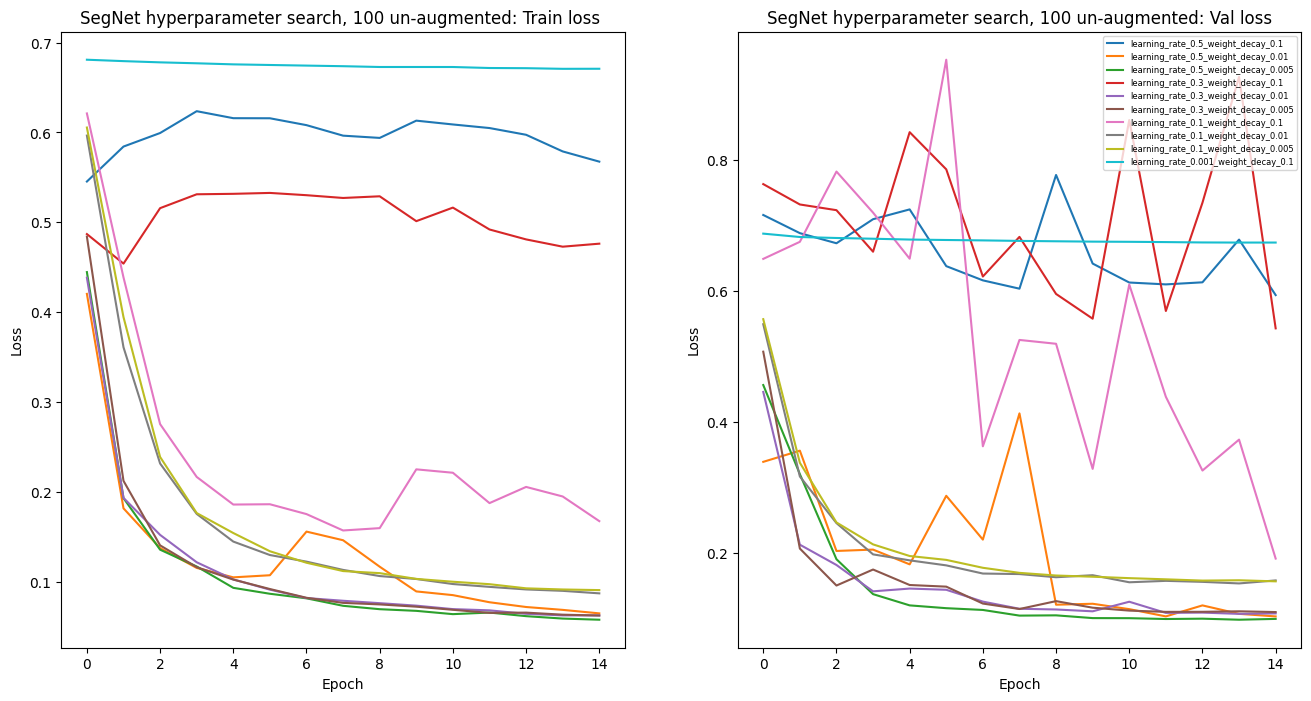

In [102]:
n_colors = 13
colors = plt.cm.tab10(np.linspace(0, 1, n_colors))

train_losses = [[loss.cpu().detach().numpy() for loss in loss_param] for loss_param in train_losses][:10]
val_losses = [[loss.cpu().detach().numpy() for loss in loss_param] for loss_param in val_losses][:10]



fig, axes = plt.subplots(1, 2, figsize=(16, 8))
print(len(train_losses[0]))
iterations = len(learning_rates) * len(weight_decays)
for i in range(len(train_losses)):
    train_losses[i] = [entry for entry in train_losses[i]]
    axes[0].plot(train_losses[i], label=combinations[i])

axes[0].set_title('SegNet hyperparameter search, 100 un-augmented: Train loss ')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

plt.legend(fontsize=6)


iterations = len(learning_rates) * len(weight_decays)
for i in range(len(val_losses)):
    axes[1].plot(val_losses[i], label=combinations[i])

axes[1].set_title('SegNet hyperparameter search, 100 un-augmented: Val loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.legend(fontsize=6)

12
13
9
9


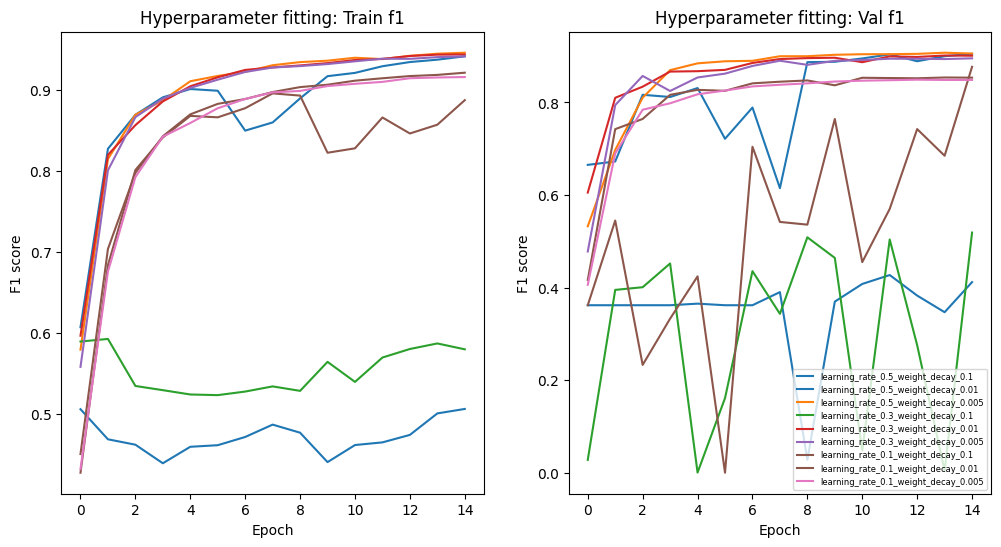

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
iterations = len(learning_rates) * len(weight_decays)

train_f1 = [[f1 for f1 in param] for param in train_f1][:9]
val_f1 = [[f1 for f1 in param] for param in val_f1][:9]
print((len(combinations)))
print((len(colors)))
print((len(train_f1)))
print((len(val_f1)))
for i in range(len(train_f1)):
    axes[0].plot(train_f1[i], label=combinations[i], color = colors[i])

axes[0].set_title('Hyperparameter fitting: Train f1')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('F1 score')

plt.legend(fontsize=6)


iterations = len(learning_rates) * len(weight_decays)

for i in range(len(val_f1)):
    axes[1].plot(val_f1[i], label=combinations[i], color = colors[i])

axes[1].set_title('Hyperparameter fitting: Val f1')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 score')

plt.legend(fontsize=6)

In [67]:
torch.save(model.state_dict(), "UnetPlusPlus_LR=.4_wd=.01.pt")

In [129]:
# Read test images
GRADIENT_COLORS = False

if GRADIENT_COLORS:
  test_images = []
  sorted_files = sorted(os.listdir(test_image_dir), key=lambda x: int(x.split('_')[1].split('(')[0]))
  c = 0
  for file in sorted_files:
    image = np.load(test_image_dir +'/' + file)
    test_images.append(image)
    print(f'{c} / {len(sorted_files)}')
    c = c + 1


else:
  test_folders = sorted(os.listdir(test_image_dir), key = extract_number)

  test_images = []
  for folder in test_folders:
    image_name = sorted(os.listdir(test_image_dir + folder))[0]
    image_path = test_image_dir + folder + '/' + image_name
    image = load_image(image_path)
    test_images.append(image)

In [138]:
threshold = 0.35 # Or MANUAL_THRESHOLD

model.eval()
predictions_raw = []
predictions_no_islands = []
predictions_post_crf = []

island_masks = []
c = 0

for i in range(len(test_images)):

  c = c + 1
  print(c)

  # Get model output
  image = torch.tensor(test_images[i]).to(device).permute(2,0,1)
  image = image.unsqueeze(0)
  output = model(image.float())
  output = torch.squeeze(output)

  # res = torch.argmax(output, dim=0).type(torch.long).cpu().detach().numpy()
  prediction = predict_patches(output, threshold)
  predictions_raw.append(prediction)
  prob_map = output.cpu().detach().numpy().astype(np.float32)

  # Removing Islands
  prediction_no_island = remove_islands(prediction)
  predictions_no_islands.append(prediction_no_island.cpu().detach().numpy())


  # Apply crf
  input_image = image[0].permute(1,2,0)
  # prediction_crf = apply_crf(input_image, prob_map)

  predicted_patches_crf = predict_patches(torch.tensor(predictions_no_islands), threshold)
  predicted_patches_crf = torch.tensor(predicted_patches_crf).unsqueeze(dim=0)
  predictions_post_crf.append(predicted_patches_crf)

1
2


<ipython-input-138-d99a1bdcb5a3>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  predicted_patches_crf = predict_patches(torch.tensor(predictions_no_islands), threshold)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [144]:
SUBMISSION_NAME = "Submission_unetplusplus_dice_LR0.5_WD0.05.csv"

In [145]:
# Generating submission
submission_filename = '/content/gdrive/MyDrive/ML/predictions/' + SUBMISSION_NAME
masks_to_submission(submission_filename, predictions_no_islands)